# Import libraries

import pandas as pd
import re

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from src.visualization.visualize import plot_confusion_matrix

In [25]:
# functions

In [10]:
def preprocessing(sentiments):
    corpus = []
    for sentiment in sentiments:
        sentiment = re.sub('[^a-zA-Z]', ' ', sentiment)
        sentiment = sentiment.lower()
        sentiment = sentiment.split()
        
        ps = PorterStemmer()
        all_stopwords = stopwords.words('english')
        all_stopwords.remove('not')
        
        sentiment = [ps.stem(word) for word in sentiment if not word in set(all_stopwords)]
        sentiment = ' '.join(sentiment)
        corpus.append(sentiment)
    return corpus

def bag_of_words(corpus, tweets):
    cv = CountVectorizer(max_features = 1500)
    X = cv.fit_transform(corpus).toarray()
    
    y = tweets.iloc[:, -1].values
    
    return X, y

def gaussiannb(X_train, y_train, X_test):
    gaussian_model = GaussianNB()
    gaussian_model.fit(X_train, y_train)
    y_pred = gaussian_model.predict(X_test)
    return y_pred

In [18]:
data = pd.read_csv('../data/external/ham-spam/spam.csv', encoding='latin-1')
data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)
data = data[['v2', 'v1']]
data['v1'] = data['v1'].map({'ham':0, 'spam':1})
data.columns = ['text', 'class']
data.head()

,text,class
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [19]:
corpus = preprocessing(data['text'])
X, y = bag_of_words(corpus, data)
X_train, X_test, y_train, y_test = train_test_split(X, y)
y_pred = gaussiannb(X_train, y_train, X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[984 211]
 [ 24 174]]


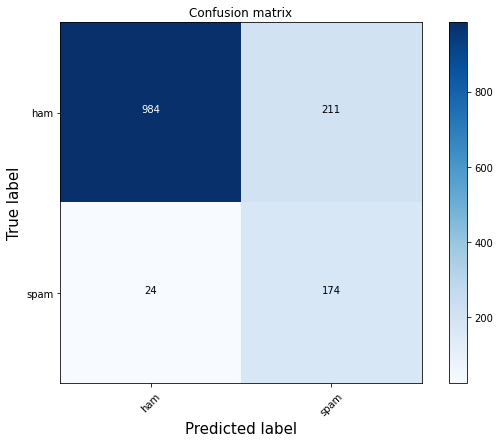

In [21]:
plot_confusion_matrix(cm, ['ham', 'spam'])

# Deep learning model

In [26]:
import numpy as np
import pandas as pd

import nltk
import nltk
#nltk.download('punkt')

from nltk import word_tokenize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torchtext
from torchtext.data import Field, BucketIterator, TabularDataset

import torch.optim as optim


def train(model, iterator, optimizer, criterion):
        
        epoch_loss = 0
        epoch_acc = 0        
        model.train()
        
        for batch in iterator:
            
            optimizer.zero_grad()
                    
            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.labels)
            
            rounded_preds = torch.round(torch.sigmoid(predictions))
            correct = (rounded_preds == batch.labels).float() 
            
            acc = correct.sum() / len(correct)
            
            loss.backward()
            
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
        return epoch_loss / len(iterator), epoch_acc / len(iterator)


class RNN(nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        # convert to embeddings
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        #creates an RNN one word at a time is feeded
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        #fully connected layer gives the outut
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        # one batch is feed. list of indexed of the word, gets the embedding
        # output: sentence length, batch size , hidden dim
        embedded = self.embedding(text)
        # one part is feeded
        # output: 1, batchsize, hidden size
        output, hidden = self.rnn(embedded)
        # just get the last hidden state for each sentence
        hidden_1D = hidden.squeeze(0)
        # double check if it is the last hidden state
        assert torch.equal(output[-1, :, :], hidden_1D)

        return self.fc(hidden_1D)


class LSTM(nn.Module):
    
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
  
        self.rnn = nn.LSTM(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        
        embedded = self.embedding(text)
        
        output, (hidden, _) = self.rnn(embedded)
        
        hidden_1D = hidden.squeeze(0)
        
        assert torch.equal(output[-1, :, :], hidden_1D)
        
        return self.fc(hidden_1D)

class LSTM_DROPOUT(nn.Module):
    
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
  
        self.rnn = nn.LSTM(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, text):
        
        embedded = self.embedding(text)
        
        embedded_dropout = self.dropout(embedded)
        
        output, (hidden, _) = self.rnn(embedded_dropout)
        
        hidden_1D = hidden.squeeze(0)
        
        assert torch.equal(output[-1, :, :], hidden_1D)
        
        return self.fc(hidden_1D)


In [29]:
if __name__ == '__main__':
    # parameters
    embedding_dim = 100
    hidden_dim = 256
    output_dim = 1    
    batch_size = 64
    num_epochs = 5
    epoch_loss = 0
    epoch_acc = 0

    
    data = pd.read_csv('../data/external/ham-spam/spam.csv', encoding='latin-1')
    data = data.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)
    data = data.rename(index = str, columns = {'v1': 'labels', 'v2': 'text'})

    train, test = train_test_split(data, test_size = 0.2, random_state = 42)
    train.reset_index(drop=True), test.reset_index(drop=True)

    train.to_csv('../data/external/ham-spam/train.csv', index=False)
    test.to_csv('../data/external/ham-spam/test.csv', index=False)

    TEXT = torchtext.data.Field(tokenize = word_tokenize)
    LABEL = torchtext.data.LabelField(dtype = torch.float)
    datafields = [("labels", LABEL), ("text", TEXT)]

    trn, tst = torchtext.data.TabularDataset.splits(path = '../data/external/ham-spam', 
                                                train = 'train.csv',
                                                test = 'test.csv' ,    
                                                format = 'csv',
                                                skip_header = True,
                                                fields = datafields)

    print(f'Number of training examples: {len(trn)}')
    print(f'Number of testing examples: {len(tst)}')
    print(trn[5].__dict__.keys())
    print(trn[5].text)
    print(trn[5].labels)
    print(print(vars(trn.examples[5])))
    
    for l in range(0,len(trn)):
        print(vars(trn.examples[l]))

    TEXT.build_vocab(trn, max_size = 10500)
    LABEL.build_vocab(trn)
    print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
    print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")
    print(TEXT.vocab.freqs.most_common(50))
    print(TEXT.vocab.itos[:10])
    print(LABEL.vocab.stoi)

    train_iterator, test_iterator = torchtext.data.BucketIterator.splits(
                                    (trn, tst),
                                        batch_size = batch_size,
                                        sort_key = lambda x: len(x.text), 
                                        sort_within_batch = False)

    input_dim = len(TEXT.vocab)
    
    model = RNN(input_dim, embedding_dim, hidden_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr = 1e-6)
    criterion = nn.BCEWithLogitsLoss()

    def train(model, iterator, optimizer, criterion):
        
        epoch_loss = 0
        epoch_acc = 0        
        model.train()
        
        for batch in iterator:
            
            optimizer.zero_grad()
                    
            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.labels)
            
            rounded_preds = torch.round(torch.sigmoid(predictions))
            correct = (rounded_preds == batch.labels).float() 
            
            acc = correct.sum() / len(correct)
            
            loss.backward()
            
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
        return epoch_loss / len(iterator), epoch_acc / len(iterator)

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)        
        print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% ')


    model.eval()
    with torch.no_grad():

        for batch in test_iterator:

            predictions = model(batch.text).squeeze(1)

            loss = criterion(predictions, batch.labels)

            rounded_preds = torch.round(torch.sigmoid(predictions))
            
            correct = (rounded_preds == batch.labels).float() 
            acc = correct.sum() / len(correct)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    test_loss = epoch_loss / len(test_iterator)
    test_acc  = epoch_acc / len(test_iterator)

    print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')



Number of training examples: 4457
Number of testing examples: 1115
dict_keys(['labels', 'text'])
['G', 'says', 'you', 'never', 'answer', 'your', 'texts', ',', 'confirm/deny']
ham
{'labels': 'ham', 'text': ['G', 'says', 'you', 'never', 'answer', 'your', 'texts', ',', 'confirm/deny']}
None
{'labels': 'ham', 'text': ['No', 'I', "'m", 'in', 'the', 'same', 'boat', '.', 'Still', 'here', 'at', 'my', 'moms', '.', 'Check', 'me', 'out', 'on', 'yo', '.', 'I', "'m", 'half', 'naked', '.']}
{'labels': 'spam', 'text': ['(', 'Bank', 'of', 'Granite', 'issues', 'Strong-Buy', ')', 'EXPLOSIVE', 'PICK', 'FOR', 'OUR', 'MEMBERS', '*', '*', '*', '*', '*', 'UP', 'OVER', '300', '%', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', 'Nasdaq', 'Symbol', 'CDGT', 'That', 'is', 'a', '$', '5.00', 'per', '..']}
{'labels': 'ham', 'text': ['They', 'r', 'giving', 'a', 'second', 'chance', 'to', 'rahul', 'dengra', '.']}
{'labels': 'ham', 'text': ['O', 'i', 'played', 'smash', 'bros', '&', 'lt', ';', '#', '&', 'gt', ';'

{'labels': 'ham', 'text': ['No', 'just', 'send', 'to', 'you', '.', 'Bec', 'you', 'in', 'temple', 'na', '.']}
{'labels': 'ham', 'text': ['Yes', 'I', 'posted', 'a', 'couple', 'of', 'pics', 'on', 'fb', '.', 'There', "'s", 'still', 'snow', 'outside', 'too', '.', 'I', "'m", 'just', 'waking', 'up', ':', ')']}
{'labels': 'ham', 'text': ['Hey', '!', '!', '!', 'I', 'almost', 'forgot', '...', 'Happy', 'B-day', 'babe', '!', 'I', 'love', 'ya', '!', '!']}
{'labels': 'ham', 'text': ['Now', 'only', 'i', 'reached', 'home', '.', '.', '.', 'I', 'am', 'very', 'tired', 'now', '.', '.', 'I', 'will', 'come', 'tomorro']}
{'labels': 'ham', 'text': ['Hey', 'anyway', 'i', 'have', 'to', ':', '-', ')']}
{'labels': 'spam', 'text': ['ASKED', '3MOBILE', 'IF', '0870', 'CHATLINES', 'INCLU', 'IN', 'FREE', 'MINS', '.', 'INDIA', 'CUST', 'SERVs', 'SED', 'YES', '.', 'L8ER', 'GOT', 'MEGA', 'BILL', '.', '3', 'DONT', 'GIV', 'A', 'SHIT', '.', 'BAILIFF', 'DUE', 'IN', 'DAYS', '.', 'I', 'O', 'å£250', '3', 'WANT', 'å£800']}
{'labe

Unique tokens in TEXT vocabulary: 10207
Unique tokens in LABEL vocabulary: 2
[('.', 3862), ('to', 1750), ('I', 1574), (',', 1468), ('you', 1462), ('?', 1256), ('!', 1134), ('a', 1068), ('the', 946), ('...', 923), ('&', 772), ('i', 760), ('and', 673), ('in', 663), ('is', 647), (';', 641), ('u', 636), ('me', 600), (':', 570), ('..', 544), ('for', 527), ('my', 494), ('of', 471), ('it', 470), ('your', 461), ('have', 395), ('on', 394), (')', 393), ('2', 390), ('that', 385), ("'s", 384), ('now', 321), ("'m", 320), ('are', 316), ('do', 312), ('call', 307), ('at', 301), ('U', 300), ('or', 298), ('not', 295), ("n't", 281), ('be', 275), ('*', 270), ('lt', 267), ('gt', 267), ('with', 267), ('get', 265), ('will', 264), ('so', 257), ('#', 245)]
['<unk>', '<pad>', '.', 'to', 'I', ',', 'you', '?', '!', 'a']
defaultdict(None, {'ham': 0, 'spam': 1})
| Epoch: 01 | Train Loss: 0.794 | Train Acc: 13.90% 
| Epoch: 02 | Train Loss: 0.756 | Train Acc: 13.86% 
| Epoch: 03 | Train Loss: 0.721 | Train Acc: 13.7